In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd

from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display
from IPython.display import Image


np.random.seed(0)

%matplotlib inline

# Multiple Linear Regression

Today we will investigate the concepts behind Multiple Linear Regression (all sources are present in a book "[Introduction To Statstical Learning with Python](https://www.statlearning.com/)".

Multiple Linear Regression is an extension of a Simple Linear Regresion. We just consider more predictor variables (more than 1.):

$$Y = \beta_0 + \beta_1X_1 + \dots + \beta_pX_p$$

For $p$ predictors, we need to estimate $p + 1$ $\beta$ coefficients.

Similar, as in a [previous post](https://islp.pomichowski.dev/blog/simple-linear-regression-fundamentals-notes/) we need to use *least squares* method to estimate those coefficients.

Today, we will do a practice exercise investigating `Advertising` dataset which is available [here](https://www.statlearning.com/s/Advertising.csv).

This dataset is about a number of units in `sales` with an increasing advertising (in 1000\$) in some media: `TV`, `radio`, `newspaper`. 

Furthermore, with our data we will answer some questions presented in a book (which you should always ask yourself when performing linear regression!):

1. *Is there a relationship between sales and advertising budget?*
2. *How strong is a relationship?*
3. *Which media are associated with a sales?*
4. *How large is the association between each medium and sales?*
5. *How accurately can we predict future sales?*
6. *Is the relationship linear?*
7. *Is there synergy among the advertising media?*

So, grab a coffee, tea or your favorite drink to answer those question presented above!

P.S. it seems a little bit odd that I am not performing `train-test` split on those data, but I want to keep a compatibility between my scores in this notebook and authors scores from a book (they performed those models on full dataset, without splitting it to train, validation and test dataset respectively).

### Reading and exploring data

In [2]:
df = pd.read_csv('../datasets/Advertising.csv', index_col=0)

df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


### We got a 200 entries with non empty cells at all in our dataset.

In [4]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### What is a relationship between predictors and response variable?

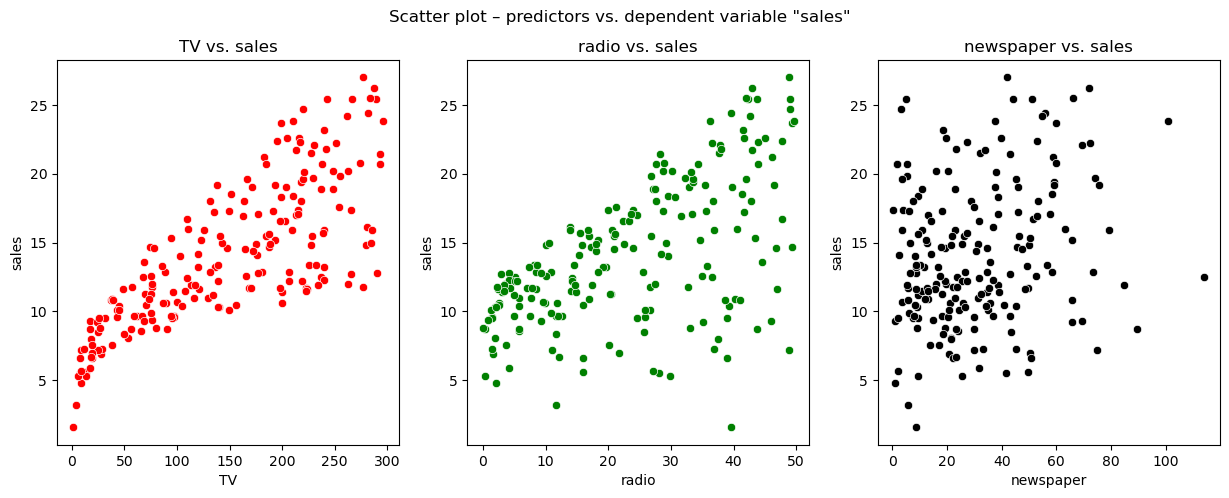

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Scatter plot – predictors vs. dependent variable "sales"')

sns.scatterplot(ax=axes[0], data=df, x='TV', y='sales', color='red')
axes[0].set_title('TV vs. sales')

sns.scatterplot(ax=axes[1], data=df, x='radio', y='sales', color='green',)
axes[1].set_title('radio vs. sales')

sns.scatterplot(ax=axes[-1], data=df, x='newspaper', y='sales', color='black')
axes[-1].set_title('newspaper vs. sales');

### From plots we can conclude that:

* the relationship between `TV` and `sales` are positive; TV increases as well as sales. The relationship does not look linear,
* the relationship between `radio` and `sales` seems also positive; The larger values of `radio` are also related with larger values of `sales`. However, we can see more dispersion of this data points compared to `TV` vs. `sales`.
* the relationship between `newspaper` and `sales` looks very disperse and we can say that probably there is no stronger relationship between this predictor and dependent varaible $Y$.

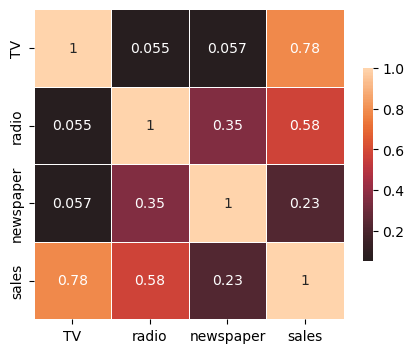

In [6]:
corr = df.corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

### From correlation matrix plot we can conclude that:

* `sales` are correlated with `TV`, the value $0.78$ suggests strong positive relationship, the predictor `TV` is not correlated with other predictors which is a good thing, because we want to avoid [*collinearity*](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/),
* `radio` has also a positive relationship between `sales` – we also see that `radio` has correlation between `newspaper` ($0.35$) which can affect our estimation of $\beta$ coefficients in regression model,
* `newspaper` as we could see also in scatter plot, does not have a strong correlation between `sales`, however $0.23$ indicates a little bit correlation between dependent variable $Y$.

### Now, this is a time to answer our questions:

### 1. *Is there a relationship between sales and advertising budget?*

To answer this question, we can use two hypothesis tests:
* *t-statistics* which will check if single coefficient $B_j = 0$ (in other words: if predictor $X_j$ has a significance on a response variable $Y$),
* *F-statistics* which will check if at least one coefficient $B_j \neq 0$ (in other words: is it at least one predictor that has a signifcance on a reponse variable.

Due to multiple linear regression we will perform *F-statistics* which will check all $\beta$ coefficients at once.

We will construct two hypthoses:
* *null hypothesis* — $H_0: \text{No predictor } X_j \text{ is associated with a response variable } Y$,
* *alternative hypothesis* — $H_a: \text{At least one predictor } X_j \text{ is associated with a response variable } Y$.

With a $\text{F-statistics} \gt 1$ and $n$ large or small with $p \lt\lt\lt n$, we have a strong evidence that there is at least one predictor associated with response variable $Y$. So, let's investigate that.

Where:
* $n$ is our number of samples,
* $p$ is our number of predictors.



In [7]:
# let's show us first n = 5 samples of our dataset 
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [8]:
model = sm.OLS.from_formula('sales ~ TV + radio + newspaper', data=df) # we pick our model using OLS (Ordinary Least Squares) from statsmodels library
# we want to regress sales onto TV + radio + newspaper
# we fit our model to estimate beta coefficients from population regression line;
results = model.fit()
results.params # we are interested in coefficients such that: beta_0 (intercept), beta_1, beta_2, beta_3 for slope

Intercept    2.938889
TV           0.045765
radio        0.188530
newspaper   -0.001037
dtype: float64

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           1.58e-96
Time:                        15:11:41   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intepretation of our `summary` method 

* $\text{F-statistics} = 570.3$ indicating a strong evidence that at least one predictor $X_j$ is associated with response variable $Y$, so we reject $H_0$ in favor of $H_a$,
* $R^{2} = 0.897$ means that 89\% variability of response variable $Y$ was explained using predictors $X_1, X_2, X_3$,
* as we can see `statsmodels` is a handful library, becuase it also performed a `t-test` to investigate whether indivdiual coefficient $B_j = 0$ in other words, whether each predictor $X_j$ has a significance on response variable $Y$,
* we see that `newspaper` with $\text{t-statistics} = -0.17$ and also $\text{std err (standard error)} = 0.006$ indicates a strong evidence that `newspaper` has no significance on our dependent variable `sales` so we can drop this predictor. Furthermore, $\text{p-value}$ is large ($\text{p-value} \gt 0.05$, so we have to reject $H_a$ in this case in favor of $H_0$). For further explanation of the Standard Error [you can follow this link here](https://islp.pomichowski.dev/blog/simple-linear-regression-fundamentals-notes),
* other predictors have a huge $t-statistics$ and also very small *standard error* which indicates a strong evidence of a significance of those predictors on a dependent variable $Y$.


The interpretation of our $\beta$ coefficients is following:

* $\beta_0 = 2.9389$ meaning, without any adveritisng in a media, we get on average 2939 units in `sales`,
* with an increase of 1000\$ in advertising `TV` — `sales` will increase approximately on average by 46 units given that other adveritising budgets are fixed (in other words: an increase in advertising `TV` does not depend on other predictors such as: `newspaper` and `radio`),
*  with an increase of 1000\$ in advertising `radio` – `sales` will increase approximately on average by 188 units given the other advertising bugets are fixed,
*  similarly with a `newspaper` coefficient, but as we mentioned before, this particular coefficient has no sense, due to lack of significance of its predictor.


### Answer \#Question 1: Yes, there is a association between advertising budget (in particular: `TV` and `radio`) between our dependent variable `sales`.

### 2. *How strong is a relationship?*

To answer this question, we can investigate some measures which will depict of a relevance of such relationship between $X$ and $Y$.

But first, let's investigate whether something changes if we delete predictor `newspaper`.

In [10]:
model = sm.OLS.from_formula('sales ~ TV + radio', data=df) # this time we fit only two predictors
# we want to regress sales onto TV + radio 
# we fit our model to estimate beta coefficients from population regression line;
results = model.fit()
results.params # we are interested in coefficients such that: beta_0 (intercept), beta_1, beta_2, for slope

Intercept    2.921100
TV           0.045755
radio        0.187994
dtype: float64

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           4.83e-98
Time:                        15:11:41   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Did you notice something without a predictors `newspaper`?


Placeholder as an image of a sweet cat for a correct answer

[Source of sweet cats](https://www.reddit.com/r/cats/comments/12kp5q0/show_me_your_cutest_sleeping_pictures_of_your_cats/)

In [12]:
display(Image(url='https://preview.redd.it/show-me-your-cutest-sleeping-pictures-of-your-cat-s-v0-hh7ke2qm4pta1.jpeg?width=1200&format=pjpg&auto=webp&s=97ac41b1d36a76a879abdc4c8d34670394f655d3', width=800, height=400))

### If you thought about it and noticed that $R^{2}$ remains unchanged, then you were correct!

As a reminder, $R^{2}$ is a proportion of a explained variability in the response variable $Y$ using predictor $X$. We see, that getting rid of `newspaper` the variability is the same, explained by `radio` and `TV` and `newspaper` has no influence at all.

It's no coincidence that, $R^{2}$ also helps us to answer a question \#2.

It explains to us how predictors affect the dispersion of dependent variable $Y$ and $R^{2} = 0.897$ indicates that `radio` and `TV` explain `sales` variability in 90\% which is a high score!

Another measure which we can use to answer question \#2, is a called $\text{RSE}$ (*Residual Standard Error*):
* *RSE* can be thought as a *lack of fit*; it measures the standard deviation of residuals from a population regression line,
* in simpler terms; if $\hat{y} \approx y$ and it's small, then we have small *RSE*; in opposite, if our prediction is poor, then we have high *RSE*,
* in much simpler terms; *RSE* tells us on average how far our predictions will deviate from a population regression line.



In [13]:

RSE = np.sqrt(np.square(results.resid).mean())

RSE

1.668703059366193

### How can we interpret that?

On average, our predictions deviate by $\pm 1668$ units in `sales`.

We can also know that $\bar{y} = 14.022$ and our $RSE \approx 1.69$, so:

$$\frac{\text{RSE}}{\bar{y}} = \frac{1.69}{14.022} \times 100\% \approx 12\%$$

Where:
* $\bar{y}$ – mean of response varible $Y$,
* $\text{RSE}$ — Residual Standard Error.

our predictions deviate from a population regression line by $12\%$ error approximately.

### Answer \#Question 2: The relationship is strong between `TV`, `radio` and `sales`. $R^{2} \approx 0.9$ indicates strong relationship as well as low $\text{RSE}$ value. 

### 3. *Which media are associated with a sales?*

Once, again we can check $\text{t-statistics}$ and $p$-value of a $\text{t-test}$ whether coefficient $\beta = 0$.

But, we also can perform *variable selection* (this is a process of selecting predictors which are associated with dependent variable $Y$).

We have 3. methods:
* *forward selection* — we start with a *null model* (i.e. no variables at all), then we create *p* simple linear regressions. We choose these models, in which we have the least value of $\text{RSS}$. And we repeat the whole process.
* *backward selection* — we start with a model with full variables (as we done before). We check corresponding $p$-values of those coefficients. When $p$-value is large, then we remove this corresponding predictor and we fit model with $p - 1$ predictors. We repeat the process.
* *mixed selection* — we start with a *null model*, we perform *forward selection*. With adding more predictors, $p$-value will increase. Then we perform *backward selection* and repeat whole process.

### Let's try *forward selection* model to check which predictor are associated with response variable

In [14]:
model = sm.OLS.from_formula('sales ~ TV', data=df)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           1.47e-42
Time:                        15:11:41   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
RSS = np.sum(np.square(results.resid))

RSS

2102.530583131351

### We can see, the $\text{RSS}$ of regressing `sales` onto `TV` equals to $2102.53$ 

In [16]:
model = sm.OLS.from_formula('sales ~ radio', data=df)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           4.35e-19
Time:                        15:11:41   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000       8.202      10.422
radio          0.2025      0.020      9.921      0.000       0.162       0.243
==============================================================================
Omnibus:                       19.358   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.910
Skew:                          -0.764   Prob(JB):                     1.75e-05
Kurtosis:                       3.544   Cond. No.                         51.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
RSS = np.sum(np.square(results.resid))
RSS

3618.479549025087

### RSS of regressing `sales` onto `radio` equals to $3618.47$

In [18]:
model = sm.OLS.from_formula('sales ~ newspaper', data=df)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Sat, 05 Aug 2023   Prob (F-statistic):            0.00115
Time:                        15:11:41   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087
==============================================================================
Omnibus:                        6.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.483
Skew:                           0.330   Prob(JB):                       0.0645
Kurtosis:                       2.527   Cond. No.                         64.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
RSS = np.sum(np.square(results.resid))
RSS

5134.804544111939

### As we can see, we can construct model with respectively `TV` and `radio` as our predictors.

The $\text{RSS of TV} \approx 2102.53$ which is the smallest value, so definitely we can add this predictor to our final model.

The $\text{RSS of radio} \approx 3618.48$ which is medium value, so definitely we can add this predictor to our final model.

The $\text{RSS of newspaper} \approx 5134.80$ which is the largest value, so we reject this predictor to our final model.

### Answer Question#3: The media associated with dependent variable are: `TV` and `radio`. Using tests like: $\text{t-statistics}$ or performing *forward selection* method we can conclude that those predictors are in fact, associated with `sales`.

### 4. *How large is the association between each medium and sales?*

To answer this question, we can calculate *confidence intervals* using standard errors of estimation our coefficients.

We can conclude how large association is between each predictor and sales based on a values from an interval.

If interval cut-offs are far from zero, we can see that in fact those predictors are associated with dependent variable and this association is small/medium/large (based on those values i.e. how far are those from 0).

We can also conclude that there is no relationship between predictor and dependent variable when *confidence interval* will contain 0 value.

So, let's investigate that! First, we will calculate those *confidence intervals* and second, we interpret them!

In [20]:
model = sm.OLS.from_formula('sales ~ TV + radio + newspaper', data=df)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 05 Aug 2023   Prob (F-statistic):           1.58e-96
Time:                        15:11:41   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Let's calculate first $\text{SE}(\beta_1)$ – which stands for Standard Error of $\beta_1$ coefficient.

Quick reminder, we calculate Standard Errors to assure how far on average, our estimation of $\beta$ coefficients deviate from a population regression line coefficients. 

The 95\% confidence interval is avaialble in our `results.summary()` method. The values of a column **[0.0025 0.975]** are the cut-offs of our interval. But, let's calculate those values manually, to learn something new!

If standard error is small, then our estimation of such unknown coeffiction of true underlying relationship between $X$ and $Y$ is decent. 

If standard error is high..., then you already know an answer. 🙂



### 1. Calculate the $\text{t-value}$ – we must find $\text{t-value}$ that corresponds to the 2.5% and 97.5% percentiles of $\text{t-distribution}$ with $n - p - 1$ degrees of freedom

Where:
* $n$ – number of samples,
* $p$ – number of predictors.


In [21]:
# number of observations (our n)

n = len(df)

print(f'Number of observations in our dataset: {n}')

# number of predictors (we are considering: TV, radio, newspaper):

p = 3

# degrees of freedom, we subtract 1 from this formula, because we don't account our intercept – beta0

deg_freedom = n - p - 1

# T-value for 95% confidence interval
t_value = t.ppf(1 - 0.025, deg_freedom)

t_value

Number of observations in our dataset: 200


1.9721412216594967

### 2. Using our `t-value` now, we calculate our margin of error for each coefficient by multiplying each coefficent by a corresponding standard error

In [22]:
results.params

Intercept    2.938889
TV           0.045765
radio        0.188530
newspaper   -0.001037
dtype: float64

In [23]:
tv_coeff = results.params[1]
radio_coeff = results.params[2]
newspaper_coeff = results.params[-1]

# We also need a corresponding standard errors of our beta coefficients:
tv_std_err = results.bse[1]
radio_std_err = results.bse[2]
newspaper_std_err = results.bse[-1]

print(f'TV coeff: {tv_coeff}, TV std err: {tv_std_err}\nradio coeff: {radio_coeff}, radio std err: {radio_std_err}\nnewspaper coeff: {newspaper_coeff}, newspaper std err: {newspaper_std_err}')

TV coeff: 0.04576464545539762, TV std err: 0.0013948968069749745
radio coeff: 0.18853001691820434, radio std err: 0.00861123396730194
newspaper coeff: -0.0010374930424761793, newspaper std err: 0.005871009647086364


### 3. Calculate confidence intervals (lower and upper bounds) for our $\beta$ coefficients

In [24]:
margin_tv_err = t_value * tv_std_err
margin_radio_err = t_value * radio_std_err
margin_newspaper_err = t_value * newspaper_std_err

lower_bound_ci_tv = tv_coeff - margin_tv_err
upper_bound_ci_tv = tv_coeff + margin_tv_err

lower_bound_ci_radio = radio_coeff - margin_radio_err
upper_bound_ci_radio = radio_coeff + margin_radio_err

lower_bound_ci_newspaper = newspaper_coeff - margin_newspaper_err
upper_bound_ci_newspaper = newspaper_coeff + margin_newspaper_err

print(f'TV confidence interval:\n[{lower_bound_ci_tv:.3f}, {upper_bound_ci_tv:.3f}]')
print(f'Radio confidence interval:\n[{lower_bound_ci_radio:.3f}, {upper_bound_ci_radio:.3f}]')
print(f'Newspaper confidence interval:\n[{lower_bound_ci_newspaper:.3f}, {upper_bound_ci_newspaper:.3f}]')

TV confidence interval:
[0.043, 0.049]
Radio confidence interval:
[0.172, 0.206]
Newspaper confidence interval:
[-0.013, 0.011]


### As we can see, we got a similar results as `results.summary()` method.

What those intervals can say about our esimations of $\beta$ coefficients?

* the real value of $\beta$ coefficients of `TV` will fall around this interval. The vales are different from $0$, so `TV` has a significance on a dependent variable $Y$,
* `radio` as well are far from $0$, so the relationship in this case is in fact large,
* `newspaper` – here we again see that this predictor is useless to predict depedent variable $Y$. As we can see, we have negative sign in lower bound of such interval, meaning that between those bounds, we get a value $0$ indicating that in fact `newspaper` does not a significance on dependent variable $Y$ (again, we have such evidence).

### Answer Question#4: Large in the context of how far our estimations of $\beta$ are from 0, so the `TV` and `radio` are large in that context. `newspaper` again showed to us, that has no relationship with a dependent variable $Y$.

### 5. How accurately can we predict future sales?

As above, if we can know how on average future sales will increase, we can use *confidence interval* to estimate those sales in increasing advertising by 1000\$ in some medium.

If we, are more interested in estimating an invidual increase in unit `sales`, we should calculate *prediction intervals* which will be always broader than *confidence intervals*, because they also include $\epsilon$ – they account the uncertanity i.e. irreducible error among a data.

So, as we calculated *confidence intervals* we'll also calculate those *prediction intervals* manually to see, learn and come up with conclusions!

First, as I mentioned earlier, in *prediction intervals* we need a single observation which we want to predict a units in `sales`.

Suppose, that we got an observation:

$$X = \left[1, 100, 100, 0\right] $$

Where:

* 1 – stands for bias unit (this is a column which `OLS` in model),
* 100 – increasing advertising in `TV` by $10 \times 1000\$$,
* 100 — increasing advertising in `radio` by $10 \times 1000\$$,
* and no increase in `newspaper` at all.

So, in order to calculate *prediction interval* for an individual observation we need:

1. Create a new observation,
2. Calculate the prediction for a new observation,
3. Calculate the standard error using:

$$SE = \sqrt{\sigma^{2}(1 + x_0^{T}(X^{T}X)^{-1}x_0}$$ 

Where:

* $\sigma^{2}$ — the mean of squared error of residuals from the fitted model,
* $x_0$ — the vector of the new observation which we want to predict (with an inclusion of 1 for an intercept term),
* $X$ – the predictor matrix of the original data, with an inclusion of a bias term (the column of ones).

4. Calculate the prediction interval:

$$\text{Pred. Inteval} = \hat{y_0} \pm t_{\alpha/2, n - p - 1} \times \text{SE}$$

Where:

* $\hat{y_0}$ – the predicted value of the new observation,
* $t_{\alpha/2, n - p - 1}$ — the $\text{t-value}$ corresponding to the desired confidence level $\alpha$ and $n - p - 1$ degrees of freedom ($n$ samples, $p$ predictors),
* $\text{SE}$ — standard error of the prediction.

In [25]:
X_new = np.array([[1, 10,  10,  0]]) # our test observation, 1 - is for an intercept as a bias term

X = sm.add_constant(df.iloc[:, :-1].to_numpy())

# coefficients from a model
coeffs = results.params

# prediction of a new observation using our coefficients
y_hat = np.dot(X_new, coeffs)

mse_resid = np.sum(np.square(results.resid)) / (n - p - 1)

se = np.sqrt(mse_resid * (1 + X_new.dot(np.linalg.inv(X.T.dot(X))).dot(X_new.T)))

t_value = t.ppf(1 - 0.05 / 2, n - p - 1)

lower = y_hat - t_value * se
upper = y_hat + t_value * se

print(f'Prediction interval for the new observation: [{lower[0][0]:.4f}, {upper[0][0]:.4f}]')

Prediction interval for the new observation: [1.9129, 8.6508]


### So, in increasing in both 10000\$ in `TV` and `radio` advertising, we get approximately $\pm 1912 — 8650$ units in `sales`

### Answer Qustion#5: Depending whether we want to get an average prediction or individual prediction accuracy we can use *confidence intervals* and *prediction intervals* to assess our accuracy.

### 6. Is the relationship linear?

To answer this question, we can plot a *residual plot* which will show us if the fit of our linear regression is sufficient to predict those data points.

So, let's plot it then!

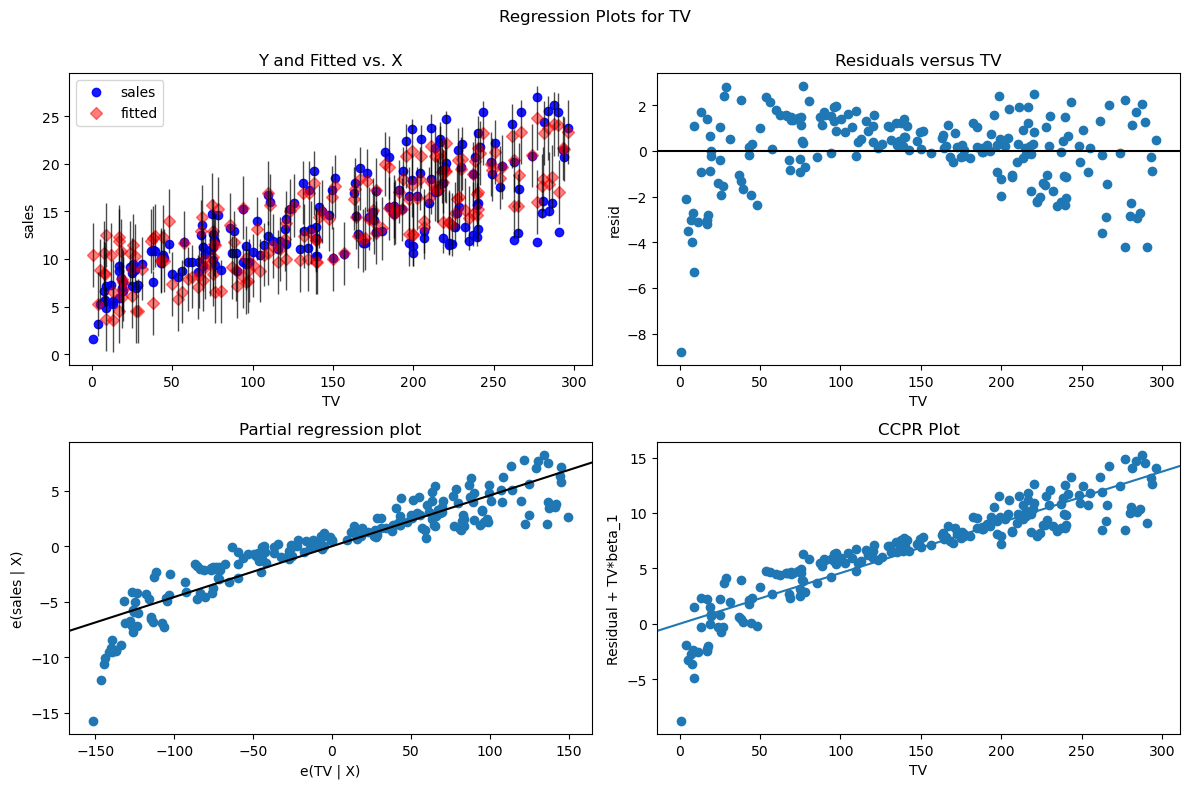

In [26]:
model = sm.OLS.from_formula('sales ~ TV + radio', data=df).fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'TV', fig=fig)

### We can see froim plots (specially in right-top corner) that the pattern of residuals is a little bit curved, which indicates more sophisticated relationship than linear one.

Let's see now how `sales` vs. `radio` looks like.

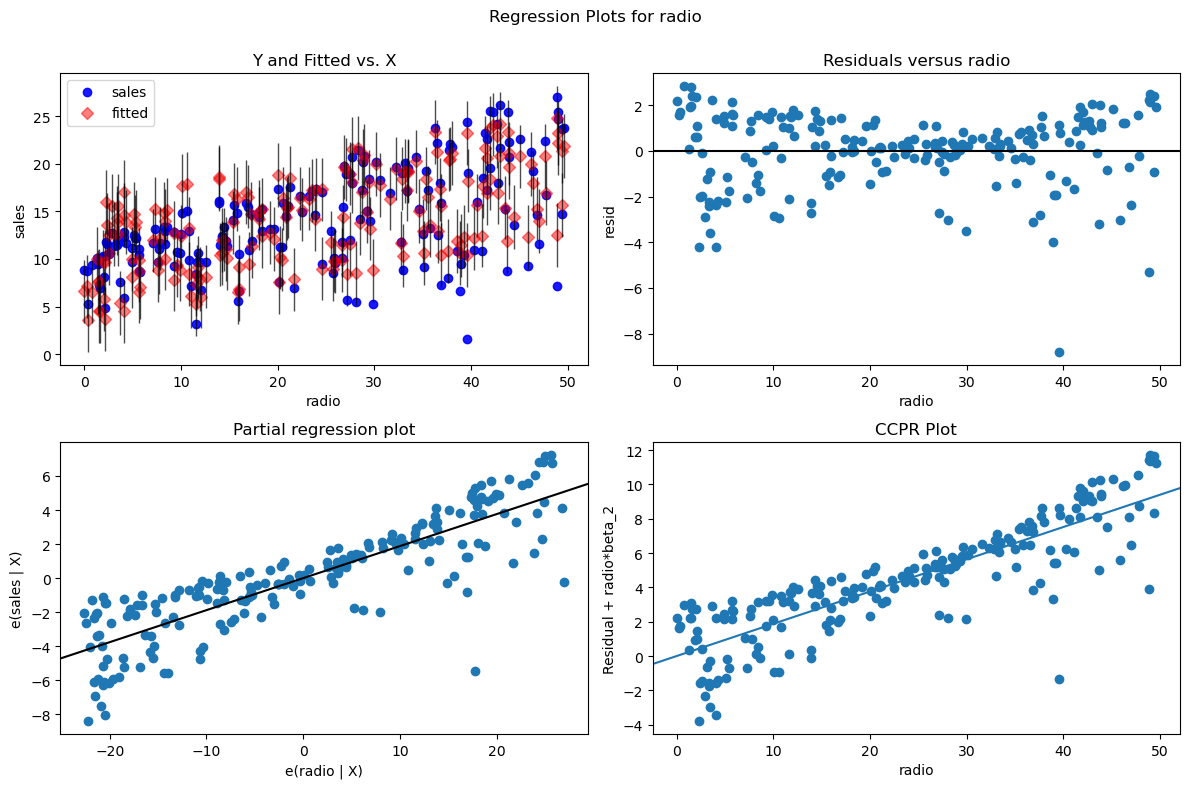

In [27]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'radio', fig=fig)

### From these residuals, we can see more inxflexible relationship than in `TV`, this approximation is kinda sufficient.

### Last, thing we can check whether our relationship is linear is also a plot a fit of our multiple linear regression. Let's see.

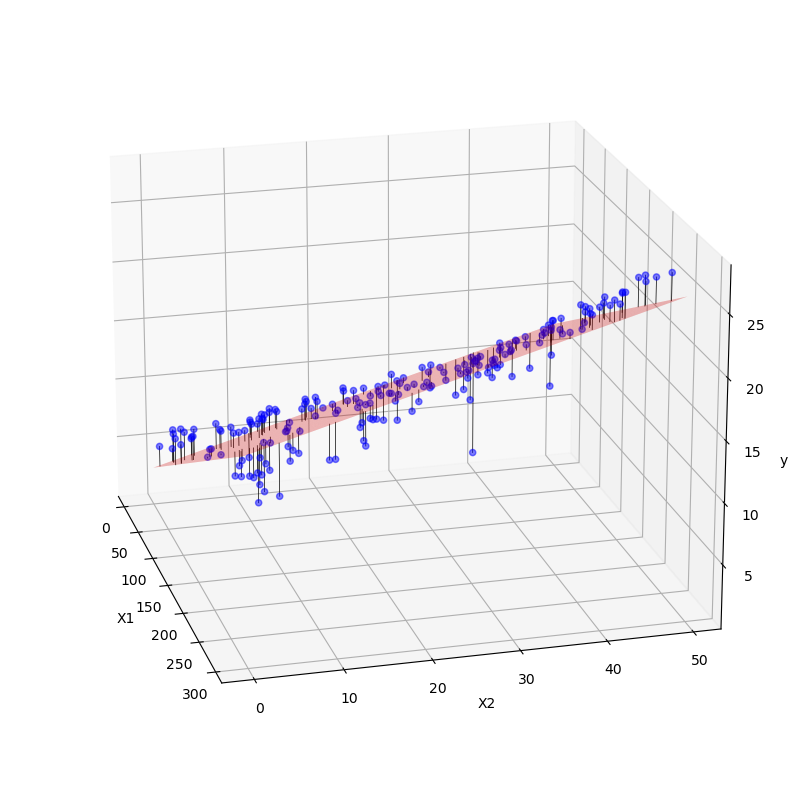

In [28]:
X1, X2 = df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X = np.column_stack((X1, X2)) # choose our predictors `TV` and `radio`
X = sm.add_constant(X) # we add a bias to this matrix of predictors

model = sm.OLS(y, X).fit() # we fit our model
y_pred = model.predict(X) # we predict y

# we create a grid of values of 
X1_grid, X2_grid = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

# predict y values for the grid
y_grid = model.predict(sm.add_constant(np.column_stack((X1_grid.ravel(), X2_grid.ravel()))))
y_grid = y_grid.reshape(X1_grid.shape)

fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(111, projection='3d')

# plot the observed values
ax.scatter(X1, X2, y, c='blue', marker='o', alpha=0.5, label='Observed')

# adding residuals error (vertical black lines) between real values of Y and hat Y (our plane)
for xi, x2i, yi, y_fitted_i in zip(X1, X2, y, y_pred):
    ax.plot([xi, xi], [x2i, x2i], [yi, y_fitted_i], color='black', linewidth=0.5)

# plot the predicted surface
ax.plot_surface(X1_grid, X2_grid, y_grid, color='red', alpha=0.3, label='Fitted')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')

ax.view_init(elev=20, azim=-15);

plt.show();

### From this plot, we can see a little curvature between $X1$ and $X2$, the red plane is our fit of multiple linear regression. 

* we can see that, our plane (estimation of relationship between $X$ and $y$) underestimates $Y$ when $X1$ and $X2$ are relatively smaller,
* we can see also, that with an increasing values of $X2$ as well as $X1$ our plane underestimates higher values of $Y$,
* we can see that due to this slightly curvature, the relationship is not linear.


### Answer Question#6: We can plot residuals plot and fit of our model to investigate if there is a linearlity between our predictors and dependent variables. As we see, in our case the relationship seems non-linear.

### 7. *Is there synergy among the advertising media?*

From a plot above, we can conclude that in fact it exists some synergy between `TV` and `radio`. Increasing `TV` may also impact a relationship between `sales` and `radio`. To check whether a synergy exists, simply multiply these predictors by each other and check corresponding $p$-values. We also can investigate the $R^{2}$ – if it increases, then yes, there exists a synergy between those predictors.
We can also fit a simple linear regression using as a predictor, a multiplied features `TV` and `radio`. Then, we check $\text{t-statistics}$ to ensure whether those synergy has a significance on dependent variable $Y$.


In [29]:
df['rad_sal_syn'] = df['TV'] * df['radio']

In [30]:
model = sm.OLS.from_formula('sales ~ TV + radio + rad_sal_syn', data=df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Sat, 05 Aug 2023   Prob (F-statistic):          6.68e-146
Time:                        15:11:44   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7502      0.248     27.233      0.000       6.261       7.239
TV              0.0191      0.002     12.699      0.000       0.016       0.022
radio           0.0289      0.009      3.241      0.001       0.011       0.046
rad_sal_syn     0.0011   5.24e-05     20.727      0.000       0.001       0.001
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of an outcomes:

* we see a strong evidence, that this synergy exists ($\text{t-statistics}$ is very large, $\text{std error}$ is very small). We also see, that in fact $R^{2}$ increased to $0.968$ from $0.897$ (including only both predictors `TV` and `radio`). We can also inspect a residuals fit to see, whether now, our fit is sufficient to capture this non-linear relationship.

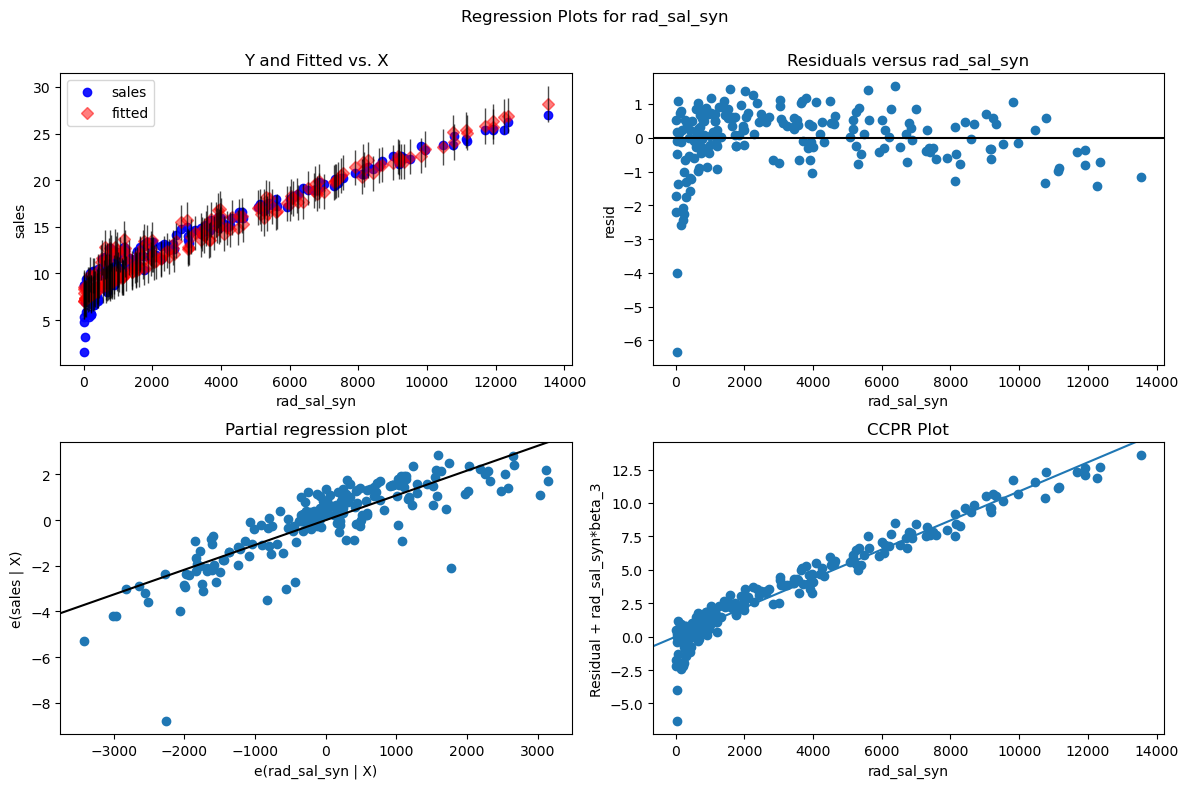

In [31]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'rad_sal_syn', fig=fig)

### We see, that in fact this relationship is captured efficiently. We could also delete some *outliers* as for example, we see at $X=0$ residuals with value of $-6$ and $-4$. 

# Summary

In this post we've discovered a plenty of information about a multiple linear regression.

We answered 7. questions that should be always answered while performing such an analysis using regression.

Thank You very much, if you made it to the end of this long post.

Take care and be happy,

KP